In [1]:
# Variables explaination link: https://api.census.gov/data/2010/dec/sf1/variables.html

"""
P001001	Total	TOTAL POPULATION	not required	P001001ERR	0	(not a predicate)	P1
P002001	Total	URBAN AND RURAL	not required	P002001ERR	0	int	P2
P002002	Total!!Urban	URBAN AND RURAL	not required		0	int	P2
P002003	Total!!Urban!!Inside urbanized areas	URBAN AND RURAL	not required		0	int	P2
P002004	Total!!Urban!!Inside urban clusters	URBAN AND RURAL	not required		0	int	P2
P002005	Total!!Rural	URBAN AND RURAL	not required		0	int	P2
P002006	Total!!Not defined for this file	URBAN AND RURAL	not required		0	int	P2
P003001	Total	RACE	not required	P003001ERR	0	int	P3
P003002	Total!!White alone	RACE	not required		0	int	P3
P003003	Total!!Black or African American alone	RACE	not required		0	int	P3
P003004	Total!!American Indian and Alaska Native alone	RACE	not required		0	int	P3
P003005	Total!!Asian alone	RACE	not required		0	int	P3
P003006	Total!!Native Hawaiian and Other Pacific Islander alone	RACE	not required		0	int	P3
P003007	Total!!Some Other Race alone	RACE	not required		0	int	P3
P003008	Total!!Two or More Races	RACE	not required		0	int	P3
P004001	Total	HISPANIC OR LATINO ORIGIN	not required	P004001ERR	0	int	P4
P004002	Total!!Not Hispanic or Latino	HISPANIC OR LATINO ORIGIN	not required		0	int	P4
P004003	Total!!Hispanic or Latino	HISPANIC OR LATINO ORIGIN
"""

# Dataset: https://api.census.gov/data/2010/dec/sf1?get=P001001,P003002,P003003,P004003,NAME&for=county:*
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

## 1 Load the dataset

In [2]:
df = pd.read_json("https://api.census.gov/data/2010/dec/sf1?get=P001001,P003002,P003003,P004003,NAME&for=county:*")


new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
new_header[0] = 'Total'
new_header[1] = 'White'
new_header[2] = 'Black'
new_header[3] = 'Hispanic or Latino'
df.columns = new_header #set the header row as the df header
df.head(10)

,Total,White,Black,Hispanic or Latino,NAME,state,county
1,125744,96344,8019,15445,"Sebastian County, Arkansas",05,131
2,17058,11949,734,5220,"Sevier County, Arkansas",05,133
3,17264,16582,93,290,"Sharp County, Arkansas",05,135
4,12394,11995,11,157,"Stone County, Arkansas",05,137
5,41639,26276,13721,1460,"Union County, Arkansas",05,139
6,17295,16598,68,475,"Van Buren County, Arkansas",05,141
7,203065,162253,6006,31458,"Washington County, Arkansas",05,143
8,77076,70425,3074,2879,"White County, Arkansas",05,145
9,22185,19226,307,4230,"Yell County, Arkansas",05,149
10,21419,13854,195,11804,"Colusa County, California",06,011


In [3]:
df[False == df['NAME'].str.contains("County")].head(10)

,Total,White,Black,Hispanic or Latino,NAME,state,county
107,97581,75175,4423,5651,"Fairbanks North Star Borough, Alaska",02,090
111,3141,660,219,385,"Aleutians East Borough, Alaska",02,013
112,5561,2004,332,726,"Aleutians West Census Area, Alaska",02,016
113,1826,1637,10,42,"Denali Borough, Alaska",02,068
114,4847,878,11,101,"Dillingham Census Area, Alaska",02,070
115,997,481,0,24,"Bristol Bay Borough, Alaska",02,060
177,601723,231471,305125,54749,"District of Columbia, District of Columbia",11,001
241,291826,192498,16226,22061,"Anchorage Municipality, Alaska",02,020
242,17013,1894,65,181,"Bethel Census Area, Alaska",02,050
243,13592,7522,92,996,"Kodiak Island Borough, Alaska",02,150


After some research, we can observe that for instance, we have the datas for Carson City, from Nevada.
This City is not part of any county (source: https://en.wikipedia.org/wiki/Carson_City,_Nevada). 
// TODO réfléchir à quoi faire de ces données, et peut être justifier qu'on a que des County dans notre stop data set (si c le cas)

In [4]:
# Given a county name and a state name, returns the number of 
# total polulation, blacks and whites.
def getStatsByCounty(countyName, stateName, df):
    # Split the NAME column in "County/City Name" and "State"
    new_df = df.copy()
    new_df[['County_name', 'State_name']] = df['NAME'].str.split(',', 1, expand=True)
    matches = new_df[new_df['County_name'].str.contains("(?i)"+countyName)].copy()
    if(len(matches) == 0):
        # Try to remove dots from the county name 
        # i.e. "St. Johns County" is "St Johns counts" in the police dataset
        matches = new_df[new_df['County_name'].str.replace('.', '').str.contains("(?i)"+countyName)].copy()
            
    matches = matches[matches['State_name'].str.contains("(?i)"+stateName)].copy()
    
    matches['Total'] = pd.to_numeric(matches['Total'])
    matches['White'] = pd.to_numeric(matches['White'])
    matches['Black'] = pd.to_numeric(matches['Black'])
    matches['Hispanic or Latino'] = pd.to_numeric(matches['Hispanic or Latino'])
    
    if(len(matches) == 0):
        print("[getStatsByCounty] Error: County not found: ", countyName)
        return;
    if(len(matches) == 1):
        return {'total': matches['Total'].values[0], 
                'white': matches['White'].values[0],
                'black': matches['Black'].values[0], 
             #   'hispanicy or latino': (matches['Hispanic or Latino']/matches['Total']).values[0]
               }
    else:
        print("[getStatyByCount] Error: Too many matches: ", countyName)
        print(matches[['County_name', 'State_name']])
        return;



In [5]:
getStatsByCounty('new york', '', df)

{'total': 1585873, 'white': 911073, 'black': 246687}

## 2 Stop data

In [7]:
data = pd.read_csv('data/search_rates.csv', low_memory=False)

# Keep only black/white subject_race
data = data[(data['subject_race'] == 'white') | (data['subject_race'] == 'black')]
data.head(10)


,county_name,state,subject_race,search_rate,count_searched,total_stops
0,Abbeville County,SC,black,0.026355,371,14077
3,Abbeville County,SC,white,0.016999,433,25472
5,Adams County,WA,black,0.038708,121,3126
8,Adams County,WA,white,0.014826,1011,68191
9,Aiken County,SC,black,0.035759,3707,103665
12,Aiken County,SC,white,0.034333,5933,172806
14,Alachua County,FL,black,0.033513,448,13368
17,Alachua County,FL,white,0.011562,383,33126
18,Allendale County,SC,black,0.060079,1210,20140
21,Allendale County,SC,white,0.081434,1065,13078


We can observe that the state in the police stops dataset is in the two letters Alpha code representation (i.e. AL). In the cencus dataset, the state columns contains the state name (i.e. Alabama).

A mapping dictionary has been found and used on github:https://gist.github.com/rogerallen/1583593



In [8]:
# From https://gist.github.com/rogerallen/1583593
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))

In [9]:
data_states_mapped = data.copy()
# Replace the state names
data_states_mapped['state'] = data['state'].map(abbrev_us_state)
# Create the cencus column for the cencus datas
data_states_mapped['cencus'] = data_states_mapped.apply(lambda x: getStatsByCounty(x['county_name'], x['state'], df), axis=1)

[getStatyByCount] Error: Too many matches:  Chester County
0           County_name       State_name
2362     Chester County   South Carolina
2366  Dorchester County   South Carolina
[getStatyByCount] Error: Too many matches:  Chester County
0           County_name       State_name
2362     Chester County   South Carolina
2366  Dorchester County   South Carolina
[getStatsByCounty] Error: County not found:  Claredon County
[getStatsByCounty] Error: County not found:  Claredon County
[getStatsByCounty] Error: County not found:  Dillion County
[getStatsByCounty] Error: County not found:  Dillion County
[getStatsByCounty] Error: County not found:  Thomas County


We can observe that in the Florida dataset, there is one arrest in the Thomas County! This county is not in florida, but in Georgia, very close to the florida border.


In [10]:
# Remove NaN cencus data (for instance ofr Thomas Couhas not been found in the Florida cencus datas)
data_states_mapped = data_states_mapped[data_states_mapped['cencus'].notna()]

In [11]:
data_states_mapped.head(10)

,county_name,state,subject_race,search_rate,count_searched,total_stops,cencus
0,Abbeville County,South Carolina,black,0.026355,371,14077,"{'total': 25417, 'white': 17691, 'black': 7187}"
3,Abbeville County,South Carolina,white,0.016999,433,25472,"{'total': 25417, 'white': 17691, 'black': 7187}"
5,Adams County,Washington,black,0.038708,121,3126,"{'total': 18728, 'white': 11703, 'black': 109}"
8,Adams County,Washington,white,0.014826,1011,68191,"{'total': 18728, 'white': 11703, 'black': 109}"
9,Aiken County,South Carolina,black,0.035759,3707,103665,"{'total': 160099, 'white': 111457, 'black': 39..."
12,Aiken County,South Carolina,white,0.034333,5933,172806,"{'total': 160099, 'white': 111457, 'black': 39..."
14,Alachua County,Florida,black,0.033513,448,13368,"{'total': 247336, 'white': 172156, 'black': 50..."
17,Alachua County,Florida,white,0.011562,383,33126,"{'total': 247336, 'white': 172156, 'black': 50..."
18,Allendale County,South Carolina,black,0.060079,1210,20140,"{'total': 10419, 'white': 2465, 'black': 7672}"
21,Allendale County,South Carolina,white,0.081434,1065,13078,"{'total': 10419, 'white': 2465, 'black': 7672}"


In [12]:
getStatsByCounty('Alachua County', 'Florida', df)

{'total': 247336, 'white': 172156, 'black': 50282}

We will now extract the rate of black people stopped and the rate of white people stopped.

In [13]:
def extractRate(race, total_stops, cencus_data):
    if race == 'black':
        return total_stops/cencus_data['black']
    else:
        return total_stops/cencus_data['white']

rates = data_states_mapped.copy()
rates['race_stop_rate'] = data_states_mapped.apply(lambda x: extractRate(x['subject_race'], x['total_stops'], x['cencus']) , axis=1)
rates.head(10)

/home/yata/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,county_name,state,subject_race,search_rate,count_searched,total_stops,cencus,race_stop_rate
0,Abbeville County,South Carolina,black,0.026355,371,14077,"{'total': 25417, 'white': 17691, 'black': 7187}",1.958675
3,Abbeville County,South Carolina,white,0.016999,433,25472,"{'total': 25417, 'white': 17691, 'black': 7187}",1.439828
5,Adams County,Washington,black,0.038708,121,3126,"{'total': 18728, 'white': 11703, 'black': 109}",28.678899
8,Adams County,Washington,white,0.014826,1011,68191,"{'total': 18728, 'white': 11703, 'black': 109}",5.826797
9,Aiken County,South Carolina,black,0.035759,3707,103665,"{'total': 160099, 'white': 111457, 'black': 39...",2.634167
12,Aiken County,South Carolina,white,0.034333,5933,172806,"{'total': 160099, 'white': 111457, 'black': 39...",1.550428
14,Alachua County,Florida,black,0.033513,448,13368,"{'total': 247336, 'white': 172156, 'black': 50...",0.265861
17,Alachua County,Florida,white,0.011562,383,33126,"{'total': 247336, 'white': 172156, 'black': 50...",0.192419
18,Allendale County,South Carolina,black,0.060079,1210,20140,"{'total': 10419, 'white': 2465, 'black': 7672}",2.625130
21,Allendale County,South Carolina,white,0.081434,1065,13078,"{'total': 10419, 'white': 2465, 'black': 7672}",5.305477


In [14]:
# We now have the rate of black people stopped and the rate of white people stopped
# We will now compute the ratio of those two different rates
# ratio = r_white / w_black

# If we have ratio > 1:  The rate of white stopped is greater than the rate of black stopped
# If we have ration < 0: The rate of black stopped is greater than the rate of white stopped

def extract_ratio(race, race_stop_rate, total_stops):
    if(race.iloc[0] == 'white'):
        return race_stop_rate.iloc[0]/race_stop_rate.iloc[1]
    else:
        return race_stop_rate.iloc[1]/race_stop_rate.iloc[0]

def appl_merge_rows(x):
    ratio = extract_ratio(x['subject_race'], x['race_stop_rate'], x['total_stops'])
    return pd.Series({'total_stops':x['total_stops'].sum(), 'ratio':ratio})
    
ratios = rates.groupby('county_name').apply(lambda x: appl_merge_rows(x))

print(len(ratios[ratios['ratio'] > 1]))
print(len(ratios[ratios['ratio'] < 1]))

ratios['ratio'].values

28
114


array([0.735103  , 0.20317365, 0.58858365, 0.72375727, 2.02103362,
       0.68822903, 0.61592781, 0.43382307, 1.31589072, 0.87271346,
       0.76465068, 0.55470382, 0.49175282, 0.70772774, 1.17239   ,
       0.52804086, 0.66378144, 0.89894364, 0.66422189, 0.4560696 ,
       0.36379663, 0.76400804, 0.89661229, 0.6376852 , 0.66827824,
       0.52877194, 0.63368448, 1.25382679, 0.24468621, 0.55616248,
       0.18105924, 1.04887991, 1.0774961 , 1.07038714, 0.60057189,
       0.40875978, 0.90679352, 0.74690692, 1.01955601, 1.27879521,
       1.72135662, 0.3980781 , 0.9856226 , 1.63430983, 2.1076796 ,
       0.        , 1.00451808, 0.77694924, 0.68143173, 0.4174685 ,
       0.50679722, 0.6910395 , 0.85981469, 1.81482756, 1.07040316,
       0.97511514, 0.66064624, 0.88504296, 0.67833306, 0.43544184,
       0.88140624, 0.25069147, 0.71989447, 0.343398  , 0.55414897,
       1.06828894, 1.32933335, 1.25009759, 0.53545385, 0.67040106,
       0.4729968 , 0.22738081, 0.29023031, 1.3520358 , 0.50043

Text(0, 0.5, 'Ratio: (white_stop_rate / black_stop_rate)')

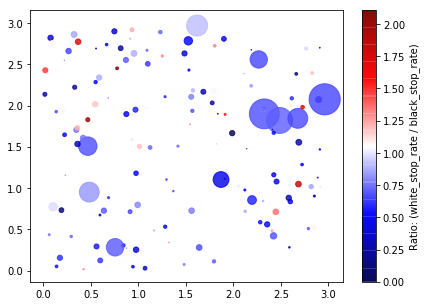

In [26]:

np.random.seed(42)

N = len(ratios)
x = np.random.rand(N)*3
y = np.random.rand(N)*3
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii


# standardize the total_stops for each county
total_stops = (ratios['total_stops'] - ratios['total_stops'].mean())/ratios['total_stops'].std()

plt.figure(figsize=(7, 5))

plt.scatter(x, y, alpha = .8, s=total_stops.values*total_stops.values*50, c = ratios['ratio'].values, cmap = 'seismic')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Ratio: (white_stop_rate / black_stop_rate)')


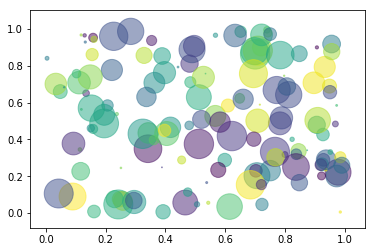

In [16]:


import seaborn as sns

import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


N = len(ratios)
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

Finally, we will use the cencus datas to "normalize" the "total_stops" of each countries.

Let imagine we have a box with 100 red balls and 50 blue balls.
After a blind pick of ball, we denote "1" for if the ball is red, and "0" if the ball is blue.
We have P(X = 1) = 2/3  and P(X = 0) = 1/3
The expected number of red balls is 2/3. We can say E[X] = 2/3.
The variance V[X] is E[X^2] - E[X]^2 = 2/3 - (2/3)^2 = 2/9

After 90 picks, we can have 95% confidence interval that the amount of red balls is between [mean - 1.96*std, mean + 1.96*std] = [60 - 1.96*20, 60*1.96*20] = ~[20.8, 99.2]. Hence, if we observe that 10 red balls are picked, we can suspect a color biais in the pick of the balls.

For instance, Alachua County of Florida has 172'156 whites and 50'282 blacks. 
There is also 33'126 whites arrest and 13'368 black arrests.
We can observe that the amount of black arrested represent a rate of 13368/50282 = 0.26 the total black population
The amount of whites stopped represents 33126/172156 = 0.19 of the white population. 

TODO